# Training Notebook

In [8]:
import numpy as np

In [9]:
from Bio import SeqIO

positives = []
negatives = []

with open("positives.fasta", "r") as input_handle:
    for record in SeqIO.parse(input_handle, "fasta"):
        positives.append(str(record.seq))
with open("negatives.fasta", "r") as input_handle:
    for record in SeqIO.parse(input_handle, "fasta"):
        negatives.append(str(record.seq))

In [10]:
positives

['MHTPIISETVQPKTAGLIVLGKASAETRGLSQGVEPDIGQTYFEESRINQD',
 'MNKQQQESGLLLAEESLMELCASSETLGGAGQYKEVEAGRWSDRIDSDDE',
 'MVRLLAKLLRSTIHGSNGVSLDAVSSTHGTPGFQTPDARVISRFGFN',
 'MERIEDHIDDELIDLGAASVETQGDVLNAPEPGIGREPTGLSRD',
 'MQRIIDETTDGLIELGAASVQTQGDVLFAPEPGVGRPPMGLSED',
 'MTKKNATQAPRLVRVGDAHRLTQGAFVGQPEAVNPLGREIQG',
 'MTKTHRLIRLGDAQRLTQGTLTPGLPEDFLPGHYMPG',
 'MTSRFQLLRLGKADRLTRGALVGLLLEDITVARYDPM',
 'MTSQPSKKTYNAPSLVQRGKFARTTAGSQLVYREWVGHSNVIKPGP',
 'MDEELELEIVDLGDAKELTQGAPSLINSEDNPAFPQRV',
 'MDRHDNSEVDEIIDLGTASAVTQGMGSGSTDQNGQPKNLIGGISDD',
 'MKQQKQQKKAYVKPSMFQQGDFSKKTAGYFVGSYKEYWSRRII',
 'MLISTTNGQGTPMTSTDELYEAPELIEIGDYAELTRCVWGGDCTDFLGCGTAWICV',
 'MIKHFHFNKLSSGKKNNVPSPAKGVIQIKKSASQLTKGGAGHVPEYFVGIGTPISFYG']

In [11]:
# License: GNU Affero General Public License v3 or later
# Taken and adapted from https://github.com/Alexamk/decRiPPter
from numpy import log2

def vectorize(sequence_list):
    vector_arr = []
    class Precursor:
        def __init__(self, sequence):
            self.sequence = sequence
            self.cys30 = ''
            self.cys20 = ''
            self.cys_ser30 = ''
            self.cys_ser20 = ''
            self.aafreq   = dict([(i,0.) for i in \
                    ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", \
                     "M", "F", "P", "S", "T", "W", "Y", "V"]])
            self.clfreq = {
                'RHK': 0.,
                'DE': 0.,
                'STNQ': 0.,
                'CGP': 0.,
                'AVIL': 0.,
                'MFYW': 0.
            }
            self.charge = ''
            self.avgcharge = ''
            self.avghydrop = ''
            self.length = len(self.sequence)
            self.entropy = ''
            self.entropyratio = ''

        def calculate_features(self):
            '''
            Wimley-White whole residue hydrophobicity interface scale
            '''
            hydrophobicity_dict = {
                'A': 0.17,
                'R': 0.81,
                'N': 0.42,
                'D': 1.23,
                'C': -0.24,
                'Q': 0.58,
                'E': 2.02,
                'G': 0.01,
                'H': 0.96,
                'I': -0.31,
                'L': -0.56,
                'K': 0.99,
                'M': -0.23,
                'F': -1.13,
                'P': 0.45,
                'S': 0.13,
                'T': 0.14,
                'W': -1.85,
                'Y': -0.94,
                'V': 0.07,
                'X': 0.
            }

            charge_dict = {
                'A': 0.,
                'R': 1.,
                'N': 0.,
                'D': -1.,
                'C': 0.,
                'Q': 0.,
                'E': -1.,
                'G': 0.,
                'H': 0.5,
                'I': 0.,
                'L': 0.,
                'K': 1.,
                'M': 0.,
                'F': 0.,
                'P': 0.,
                'S': 0.,
                'T': 0.,
                'W': 0.,
                'Y': 0.,
                'V': 0.,
                'X': 0.
            }

            # --- cys20/30; includes normalization in case a peptide is shorter than 30 aa
            if self.length < 20:
                self.cys30 = self.sequence.count('C') / float(self.length)
                self.cys20 = self.sequence.count('C') / float(self.length)
                self.cys_ser30 = (self.sequence.count('C') +
                                  self.sequence.count('S')) / float(self.length)
                self.cys_ser20 = (self.sequence.count('C') +
                                  self.sequence.count('S')) / float(self.length)

            elif 20 <= self.length < 30:
                self.cys30 = self.sequence.count('C') / float(self.length)
                self.cys_ser30 = (self.sequence.count('C') +
                                  self.sequence.count('S')) / float(self.length)
                self.cys20 = max([self.sequence[rng:rng+20].count('C') / float(len(self.sequence[rng:rng+20])) \
                          for rng in range(0,self.length,1) if len(self.sequence[rng:rng+20])==20])
                self.cys_ser20 = max([(self.sequence[rng:rng+20].count('C') + self.sequence[rng:rng+20].count('S')) \
                          / float(len(self.sequence[rng:rng+20])) for rng in range(0,self.length,1) if \
                          len(self.sequence[rng:rng+20])==20])

            else:
                self.cys30 = max([self.sequence[rng:rng+30].count('C') / float(len(self.sequence[rng:rng+30])) \
                          for rng in range(0,self.length,1) if len(self.sequence[rng:rng+30])==30])
                self.cys20 = max([self.sequence[rng:rng+20].count('C') / float(len(self.sequence[rng:rng+20])) \
                          for rng in range(0,self.length,1) if len(self.sequence[rng:rng+20])==20])
                self.cys_ser30 = max([(self.sequence[rng:rng+30].count('C') + self.sequence[rng:rng+30].count('S')) \
                          / float(len(self.sequence[rng:rng+30])) for rng in range(0,self.length,1) if \
                          len(self.sequence[rng:rng+30])==30])
                self.cys_ser20 = max([(self.sequence[rng:rng+20].count('C') + self.sequence[rng:rng+20].count('S')) \
                          / float(len(self.sequence[rng:rng+20])) for rng in range(0,self.length,1) if \
                          len(self.sequence[rng:rng+20])==20])

            # --- aafreq
            for aa in self.aafreq.keys():
                self.aafreq[aa] = self.sequence.count(aa) / float(self.length)

            # --- clfreq
            for aas in self.clfreq.keys():
                self.clfreq[aas] = sum([self.sequence.count(aa)
                                        for aa in aas]) / float(self.length)

            # --- charge & avgcharge
            self.charge = sum(
                [charge_dict[aa] for aa in self.sequence if aa in self.aafreq])
            self.avgcharge = self.charge / float(self.length)

            # --- avghydrop
            self.avghydrop = sum([
                hydrophobicity_dict[aa]
                for aa in self.sequence if aa in self.aafreq
            ]) / float(self.length)

            # --- k-tuplet entropy
            Es = []
            for rng in range(self.length):
                s = 0.
                seqtmp = self.sequence[rng:rng + 10]
                if 1:  #len(seqtmp)==10:
                    for i in range(1, len(seqtmp)):
                        try:                        s -= self.aafreq[seqtmp[i]]*self.aafreq[seqtmp[i]]*self.aafreq[seqtmp[i-1]] \
                            *log2(self.aafreq[seqtmp[i]]*self.aafreq[seqtmp[i-1]])
                        except KeyError:
                            pass
                Es.append(s)
            self.entropy = max(Es)

            # --- entropy ratio
            Es = []
            for rng in range(self.length):
                s = 0.
                seqtmp = self.sequence[rng:rng + 10]
                if len(seqtmp) < 5: continue
                aatmp = set(seqtmp)
                stotal = -sum([
                    self.aafreq[i] * log2(self.aafreq[i])
                    for i in aatmp if i in self.aafreq
                ])
                stemp = -sum([(seqtmp.count(i) / 10.) * log2(
                    (seqtmp.count(i) / 10.)) for i in aatmp if i in self.aafreq])
                try:
                    Es.append(stemp / stotal)
                except ZeroDivisionError:
                    Es.append(2.)
            try:
                self.entropyratio = min(Es)
            except:
                raise ValueError('Error with min(Es) on smORF with sequence %s' %
                                 self.sequence)

        def make_list(self):

            aalist = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", \
                     "M", "F", "P", "S", "T", "W", "Y", "V"]
            cllist = ['RHK', 'DE', 'STNQ', 'CGP', 'AVIL', 'MFYW']

            L = []
            L += [self.aafreq[aa] for aa in aalist]
            L += [self.clfreq[aa] for aa in cllist]
            L += [
                self.cys30, self.cys20, self.charge, self.avgcharge,
                self.avghydrop, self.entropy, self.entropyratio
            ]

            return L

        def get_features(self):
            feature_list = [
                self.sequence, self.cys30, self.cys20, self.cys_ser30,
                self.cys_ser20, self.charge, self.avgcharge, self.avghydrop,
                self.length, self.entropy, self.entropyratio
            ]
            amino_acids = self.aafreq.keys()
            clusters = self.clfreq.keys()
            sorted(clusters)
            sorted(amino_acids)
            feature_list += [self.aafreq[aa] for aa in amino_acids]
            feature_list += [self.clfreq[cl] for cl in clusters]
            return feature_list


    '''
    Precursor = Precursor('METEKYLQVVEDEEIEQLVGGAGPGWVETLTKDCPWNVPVACVTIMGQRICKKCY')
    #Precursor = Precursor('MNKDIDLSAIEISDLISETEQSDDALSQVMAASCTTTGCACSSSSSST')
    Precursor.calculate_features()

    print Precursor.sequence, Precursor.cys30, Precursor.cys20, Precursor.entropy
    print Precursor.aafreq
    print Precursor.clfreq
    print Precursor.charge, Precursor.avgcharge, Precursor.avghydrop, Precursor.length
    '''
    for seq in sequence_list:
        new_vec = Precursor(seq)
        new_vec.calculate_features()
        vector_arr.append(new_vec.get_features()[1:])
    return vector_arr


In [12]:
pos_matrix = np.matrix(vectorize(positives))
neg_matrix = np.matrix(vectorize(negatives))

## Principal Component Analysis
Quick visualization to see the vector space in three principal components

In [13]:
normal_neg = neg_matrix - np.mean(neg_matrix,0)
normal_pos = pos_matrix - np.mean(pos_matrix,0)

In [14]:
S = np.transpose(normal_neg) @ normal_neg
S = S / len(normal_neg)
print(S.shape)
val, vec = np.linalg.eigh(S)
b1 = vec[0]
# b1 = b1.reshape(b1.shape[0], 1)
b2 = vec[1]
# b2 = b2.reshape(b2.shape[0], 1)
b3 = vec[2]
# b3 = b3.reshape(b3.shape[0], 1)

(36, 36)


In [15]:
x_n = b1 @ np.transpose(normal_neg)
y_n = b2 @ np.transpose(normal_neg)
z_n = b3 @ np.transpose(normal_neg)
x_p = b1 @ np.transpose(normal_pos)
y_p = b2 @ np.transpose(normal_pos)
z_p = b3 @ np.transpose(normal_pos)

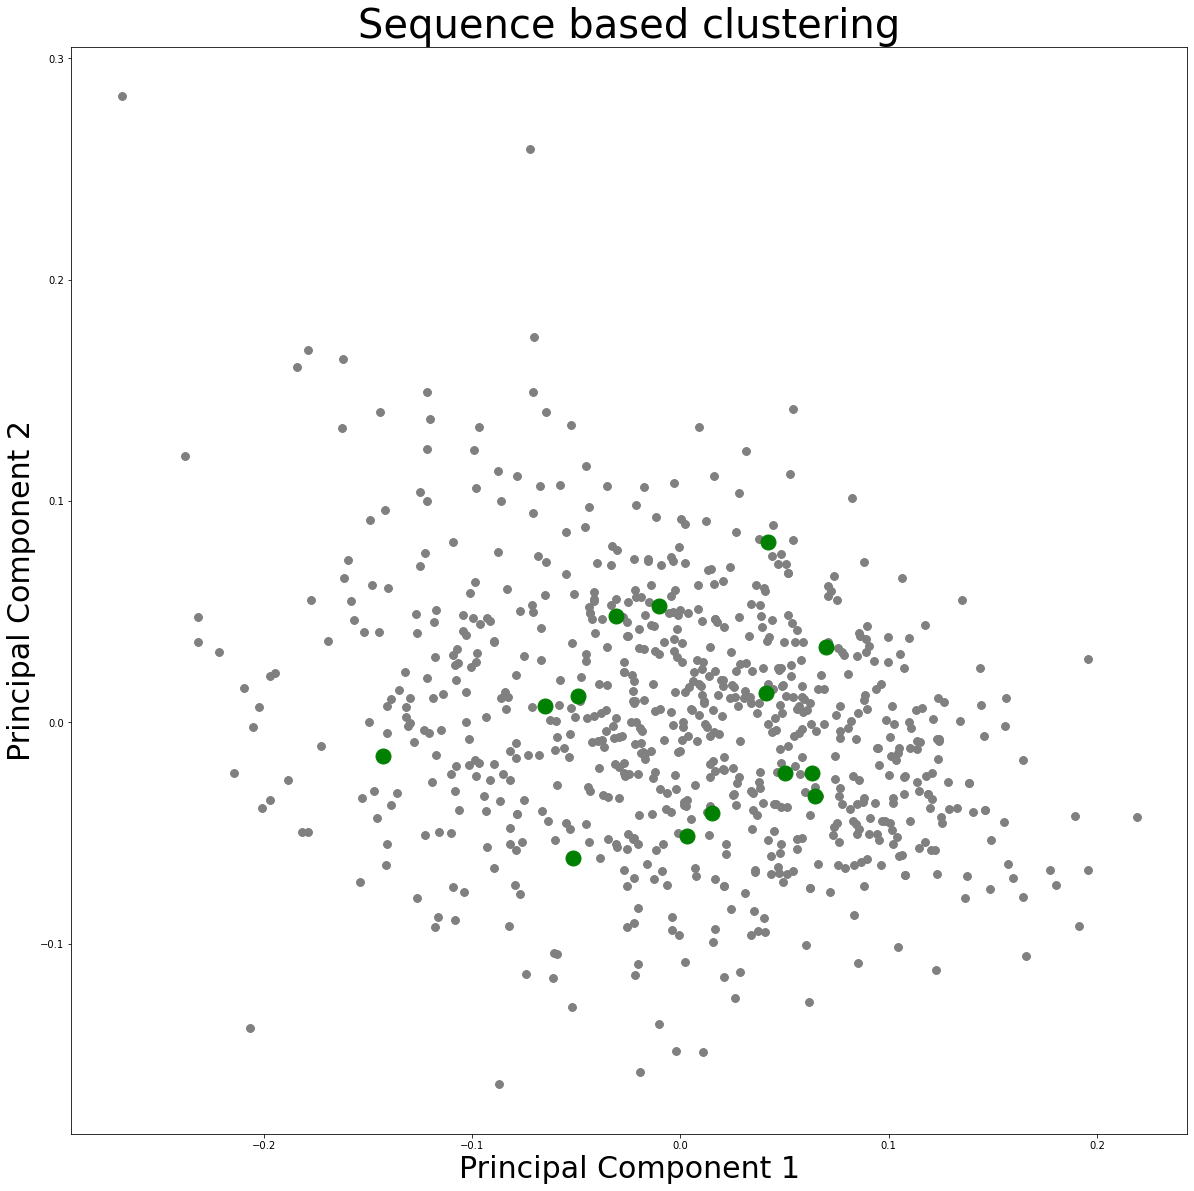

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20));
plt.xlabel("Principal Component 1", fontsize=30);
plt.ylabel("Principal Component 2", fontsize=30);
plt.title("Sequence based clustering", fontsize=40);
plt.plot(x_n, y_n, '.', color="gray", markersize=15);
plt.plot(x_p, y_p, '.', color="green", markersize=30);

## SVM Training

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
pos_train, pos_test = train_test_split(pos_matrix, test_size=0.33, random_state=42)
neg_train, neg_test = train_test_split(neg_matrix, test_size=0.33, random_state=42)

In [19]:
training_matrix = np.concatenate((pos_train, neg_train[0:100]))
testing_matrix = np.concatenate((pos_test, neg_test))

In [20]:
training_labels = np.zeros((training_matrix.shape[0],))
training_labels[:pos_train.shape[0]] += 1

In [21]:
testing_labels = np.zeros((testing_matrix.shape[0],), dtype=int)
testing_labels[:pos_test.shape[0]] += 1

In [22]:
from sklearn import svm
clf = svm.SVC(kernel="sigmoid", probability=True)

In [23]:
clf.fit(training_matrix, training_labels)

SVC(kernel='sigmoid', probability=True)

In [24]:
predictions = clf.predict(testing_matrix)

In [25]:
false_positives = 0
false_negatives = 0
true_positives = 0
true_negatives = 0
for ind in range(0, len(predictions)):
    if(testing_labels[ind] == 1):
        if(predictions[ind] == 1):
            true_positives += 1
        else:
            false_negatives += 1
    else:
        if(predictions[ind] == 1):
            false_positives += 1
        else:
            true_negatives += 1

In [26]:
print(f'True Positives: {true_positives}')
print(f'False Positives: {false_positives}')
print(f'True Negatives: {true_negatives}')
print(f'False Negatives: {false_negatives}')
print('----------------------------------')
print(f'Sensitivity: {true_positives / (true_positives + false_negatives)}')
print(f'Specificity: {true_negatives / (true_negatives + false_positives)}')

True Positives: 0
False Positives: 0
True Negatives: 501
False Negatives: 5
----------------------------------
Sensitivity: 0.0
Specificity: 1.0


In [27]:
predictions = clf.predict_proba(testing_matrix)

In [28]:
predictions[0:15]

array([[0.83777993, 0.16222007],
       [0.75021491, 0.24978509],
       [0.84693696, 0.15306304],
       [0.90043735, 0.09956265],
       [0.77156112, 0.22843888],
       [0.80224235, 0.19775765],
       [0.93731673, 0.06268327],
       [0.94555537, 0.05444463],
       [0.93731673, 0.06268327],
       [0.96392216, 0.03607784],
       [0.98457967, 0.01542033],
       [0.88090862, 0.11909138],
       [0.88258246, 0.11741754],
       [0.87822331, 0.12177669],
       [0.95152653, 0.04847347]])

In [29]:
def lasso_classifier(sequence_list):
    return(np.matrix(clf.predict_proba(vectorize(sequence_list)))[:,1])

In [30]:
positive_scores = lasso_classifier(positives)
negative_scores = lasso_classifier(negatives)

In [31]:
print(f'Average positive score: {np.sum(positive_scores) / len(positives)}')
print(f'Average negative score: {np.sum(negative_scores) / len(negatives)}')

Average positive score: 0.1800002393546689
Average negative score: 0.11752146779545895


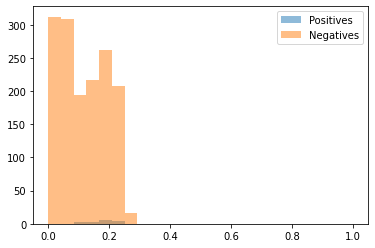

In [32]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0, 1, 25)

pyplot.hist(positive_scores, bins, alpha=0.5, label='Positives')
pyplot.hist(negative_scores, bins, alpha=0.5, label='Negatives')
pyplot.legend(loc='upper right')
pyplot.show()

In [33]:
len(positive_scores)

14

In [34]:
fpr = []
tpr = []
true_positives = len(positive_scores)
true_negatives = len(negative_scores)
for cutoff in np.linspace(0,1,25):
    tpr.append(np.sum(positive_scores >= cutoff) / true_positives)
    fpr.append(1 - (np.sum(negative_scores < cutoff) / true_negatives))

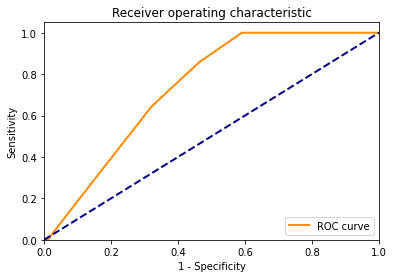

In [35]:
pyplot.figure()
lw = 2
pyplot.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('1 - Specificity')
pyplot.ylabel('Sensitivity')
pyplot.title('Receiver operating characteristic')
pyplot.legend(loc="lower right")
pyplot.show()

# Export Models

In [36]:
import dill as pickle

with open('SVMsigmoid.pickle', 'wb') as f:
    pickle.dump(clf, f)
with open('vectorize.pickle', 'wb') as f:
    pickle.dump(vectorize, f)

# Run Classifier
Load and test the classifier function

In [5]:
import dill as pickle
import numpy as np
from numpy import log2

with open('SVMsigmoid.pickle', 'rb') as g:
    clf = pickle.load(g)
with open('vectorize.pickle', 'rb') as g:
    vectorize = pickle.load(g)

In [6]:
def classify(sequence_list):
    return(np.matrix(clf.predict_proba(vectorize(sequence_list)))[:,1])

In [7]:
classify(["MYPLAIGHEPGVIGTGAEDFTVLIGGGFELNLEGGLRCRTDQG"])

matrix([[0.19417684]])